# 4. Finding transition matrix (hidden states > open channels)

In this notebook, we show how you could go about tuning a transition matrix.

In [1]:
# We will use category 2 data again
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('../data/train_2.csv')
test = pd.read_csv('../data/test_2.csv')

BATCHES = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 65, 70])
CATEGORIES = np.array([1, 1, 2, 3, 5, 4, 2, 3, 4, 5, 6, 3, 4, 6, 2, 5, 4, 5, 6, 3, 6, 6])
CATEGORY = 2

signal = np.concatenate((train['signal'].values, test['signal'].values))

ix = np.where(CATEGORIES == CATEGORY)[0]
starts = BATCHES[ix]
ends = BATCHES[ix + 1]

X = []
y = []
for start, end in zip(starts, ends):
    subsignal = signal[start*100_000:end*100_000]
    if start < 50:
        subchannels = train['open_channels'].values[start*100_000:end*100_000]
    else:
        subchannels = [-1]*((end-start)*100_000)
        
    if start == 35:
        subsignal = list(subsignal[:100000]) + list(subsignal[-100000:])
        subchannels = list(subchannels[:100000]) + list(subchannels[-100000:])
    
    X.extend(subsignal)
    y.extend(subchannels)
    
X = np.array(X)
y = np.array(y)
print(len(X), len(y))

1100000 1100000


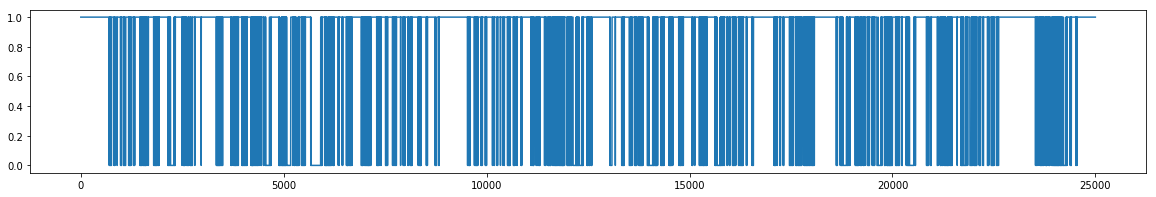

In [2]:
# We can see "blocks" of open channels = 0 (where it does switches back and forth between 0 and 1)
# and blocks of open_channels = 1 for a long period.
plt.figure(figsize=(20, 3))
plt.plot(y[y >= 0][:25000])
plt.show()

In [3]:
np.sum(y == 0)/np.sum(y >= 0), np.sum(y == 1)/np.sum(y >= 0)

(0.249199, 0.750801)

In [4]:
def markov_p_trans(states):
    # https://www.kaggle.com/friedchips/the-viterbi-algorithm-a-complete-solution
    max_state = np.max(states)
    states_next = np.roll(states, -1)
    matrix = []
    for i in range(max_state + 1):
        current_row = np.histogram(states_next[states == i], bins=np.arange(max_state + 2))[0]
        if np.sum(current_row) == 0: # if a state doesn't appear in states...
            current_row = np.ones(max_state + 1) / (max_state + 1) # ...use uniform probability
        else:
            current_row = current_row / np.sum(current_row) # normalize to 1
        matrix.append(current_row)
    return np.array(matrix)

# We will use the self-transition probabilities for the hidden states that
# are not connected to another open_channel value and the other transition
# probabilities for the states that are connected to other open_channel values
markov_p_trans(y[y >= 0])

array([[0.80778815, 0.19221185],
       [0.0637972 , 0.9362028 ]])

In [5]:
from hmmlearn.hmm import GaussianHMM

# We now create a very rudimentary transition matrix and optimize it with hmmlearn
# Use EPS to make it possible for hmmlearn to introduce new transitions
# Feel free to do some crazy stuff with this transition matrix, you will find out 
# that hmmlearn is pretty robust and most often will still converge to our final Ptran
EPS = 1e-5
# This Ptran below will change a lot after optimization with hmmlearn...
Ptran = [
    # open_channels=0, make link to 1 for faster switching
    [0.8 - EPS , 0.19          , 0.01          , EPS           ],
    # open_channels=0, bridge to open_channels=1
    [EPS       , 0.81 - 2 * EPS, 0.19          , EPS           ],
    # open_channels=1, bridge to open_channels=0
    [EPS       , 0.06          , 0.94 - 2 * EPS, EPS           ],
    # open_channels=1, safeguard to have consecutive block of open_channels=1
    [EPS       , EPS           , 0.06          , 0.94 - 2 * EPS],
]

means = []
covs = []
for c in sorted(np.unique(y[y >= 0])):
    means.append(np.mean(X[y == c]))
    covs.append(np.cov(X[y == c]))
    
means = [means[0], means[0], means[1], means[1]]
covs = [covs[0], covs[0], covs[1], covs[1]]
    
# Defining our HMM
hmm = GaussianHMM(
    n_components=4,                     # Number of hidden states
    n_iter=50,                          # Total number of iterations
    verbose=True,                       # Show logs
    algorithm='map',                    # Use maximum a posteriori instead of Viterbi
    params='stmc',                      # Optimize start probs, transmat, means, covs
    random_state=42,
    init_params='s',                    # Manually initialize all but start probabilities
    covariance_type='full',             # Separate covariance per hidden state
    tol=0.01                            # Convergence criterion
)

# Initialize the parameters of our HMM
hmm.n_features = 1
hmm.means_ = np.array(means).reshape(-1 ,1)
hmm.covars_ = np.array(covs).reshape(-1, 1, 1)
hmm.transmat_ = Ptran

# Fit our HMM
_ = hmm.fit(X.reshape(-1, 1), lengths=[100000]*(len(X) // 100000))

         1     -113547.4388             +nan
         2      -96294.4678      +17252.9709
         3      -76232.4059      +20062.0620
         4      -64968.4441      +11263.9618
         5      -58924.9086       +6043.5355
         6      -56658.0773       +2266.8313
         7      -55980.8000        +677.2773
         8      -55789.7192        +191.0807
         9      -55734.4260         +55.2932
        10      -55717.5916         +16.8344
        11      -55712.0951          +5.4965
        12      -55710.0964          +1.9987
        13      -55709.2417          +0.8547
        14      -55708.7967          +0.4450
        15      -55708.5205          +0.2762
        16      -55708.3273          +0.1932
        17      -55708.1827          +0.1446
        18      -55708.0702          +0.1125
        19      -55707.9807          +0.0894
        20      -55707.9085          +0.0722
        21      -55707.8495          +0.0590
        22      -55707.8009          +0.0486
        23

In [6]:
np.set_printoptions(linewidth=200)
Ptran_opt = hmm.transmat_

In [7]:
# We use the Ptran_opt in a somewhat shuffled form (first the hidden states corresponding
# to open_channels=1 and then those to open_channels=0)
print(Ptran_opt[[3, 2, 1, 0], :][:, [3, 2, 1, 0]])

[[9.87847219e-01 1.21358191e-02 3.05958239e-07 1.66563644e-05]
 [4.09861162e-02 6.72181939e-01 2.83293460e-01 3.53848475e-03]
 [1.23487547e-03 2.51394819e-01 7.42725616e-01 4.64468969e-03]
 [5.66528645e-04 6.06743075e-07 2.35454665e-02 9.75887398e-01]]


In [8]:
# We adjusted this matrix slightly in order to optimize our train F1 score during the
# competition. Our final Ptran for this category, displayed below, was very close:
Ptran = [[0.9879, 0.0121, 0     , 0     ],
         [0.0424, 0.6709, 0.2766, 0.0101],
         [0     , 0.2588, 0.7412, 0     ],
         [0     , 0.0239, 0     , 0.9761]]

In [9]:
# The Ptran for categories 3, 4 and 5 is only slightly different from his one
# and was again constructed iteratively (manual changes, hmmlearn, ...) while tuning
# the macro F1 score.